Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 200s 4s/step - accuracy: 0.9571 - dice_coef: 0.2142 - iou_score: 0.1868 - loss: 0.7744 - val_accuracy: 0.9547 - val_dice_coef: 0.2684 - val_iou_score: 0.2484 - val_loss: 0.2025 - learning_rate: 0.0010
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 34s 685ms/step - accuracy: 0.9600 - dice_coef: 0.2739 - iou_score: 0.2498 - loss: 0.1746 - val_accuracy: 0.9547 - val_dice_coef: 0.2712 - val_iou_score: 0.2530 - val_loss: 0.2280 - learning_rate: 0.0010
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 34s 686ms/step - accuracy: 0.9633 - dice_coef: 0.2898 - iou_score: 0.2617 - loss: 0.1370 - val_accuracy: 0.9547 - val_dice_coef: 0.3087 - val_iou_score: 0.2725 - val_loss: 0.1411 - learning_rate: 0.0010
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 35s 709ms/step - accuracy: 0.9608 - dice_coef: 0.3055 - iou_score: 0.2700 - loss: 0.1331 - val_accuracy: 0.9547 - val_dice_coef: 0.3195 - val_iou_score: 0.2773 - val_loss: 0.1331 - learning_rate: 0.0010
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 

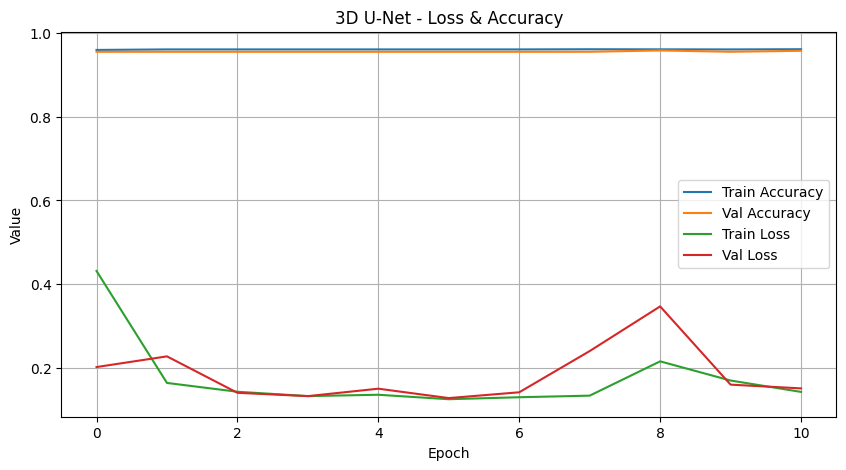

In [1]:
# Script: unet3d_training.py
# Purpose: Train a 3D U-Net model using a data generator on sampled_128

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from glob import glob
from tensorflow.keras import layers, models
from tensorflow.keras.utils import Sequence

# -------------------------------
# 1. MOUNT GOOGLE DRIVE
# -------------------------------
from google.colab import drive
drive.mount('/content/drive')
data_path = "/content/drive/MyDrive/sampled_128"

# -------------------------------
# 2. DATA GENERATOR with DOWNSAMPLING
# -------------------------------
class VolumeDataGenerator(Sequence):
    def __init__(self, image_dir, mask_dir, batch_size=1, shuffle=True):
        self.image_paths = sorted(glob(os.path.join(image_dir, '*.npy')))
        self.mask_paths = sorted(glob(os.path.join(mask_dir, '*.npy')))
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def __getitem__(self, idx):
        batch_img_paths = self.image_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_mask_paths = self.mask_paths[idx * self.batch_size:(idx + 1) * self.batch_size]

        images = [np.load(p).astype(np.float32)[::2, ::2, ::2, :] for p in batch_img_paths]
        masks = [np.load(p).astype(np.float32)[::2, ::2, ::2, :] for p in batch_mask_paths]

        return np.array(images), np.array(masks)

    def on_epoch_end(self):
        if self.shuffle:
            temp = list(zip(self.image_paths, self.mask_paths))
            np.random.shuffle(temp)
            self.image_paths, self.mask_paths = zip(*temp)

# -------------------------------
# 3. U-NET 3D MODEL
# -------------------------------
def unet3d(input_shape=(64,64,64,3), n_classes=4):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv3D(16, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv3D(16, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling3D((2,2,2))(c1)

    c2 = layers.Conv3D(32, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv3D(32, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling3D((2,2,2))(c2)

    c3 = layers.Conv3D(64, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv3D(64, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling3D((2,2,2))(c3)

    # Bridge
    b = layers.Conv3D(128, 3, activation='relu', padding='same')(p3)
    b = layers.Conv3D(128, 3, activation='relu', padding='same')(b)

    # Decoder
    u3 = layers.UpSampling3D((2,2,2))(b)
    u3 = layers.Concatenate()([u3, c3])
    d3 = layers.Conv3D(64, 3, activation='relu', padding='same')(u3)
    d3 = layers.Conv3D(64, 3, activation='relu', padding='same')(d3)

    u2 = layers.UpSampling3D((2,2,2))(d3)
    u2 = layers.Concatenate()([u2, c2])
    d2 = layers.Conv3D(32, 3, activation='relu', padding='same')(u2)
    d2 = layers.Conv3D(32, 3, activation='relu', padding='same')(d2)

    u1 = layers.UpSampling3D((2,2,2))(d2)
    u1 = layers.Concatenate()([u1, c1])
    d1 = layers.Conv3D(16, 3, activation='relu', padding='same')(u1)
    d1 = layers.Conv3D(16, 3, activation='relu', padding='same')(d1)

    outputs = layers.Conv3D(n_classes, 1, activation='softmax')(d1)

    model = models.Model(inputs, outputs)
    return model

# -------------------------------
# 4. METRICS
# -------------------------------
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_f = tf.reshape(y_true, [-1, tf.shape(y_true)[-1]])
    y_pred_f = tf.reshape(y_pred, [-1, tf.shape(y_pred)[-1]])
    intersection = tf.reduce_sum(y_true_f * y_pred_f, axis=0)
    union = tf.reduce_sum(y_true_f, axis=0) + tf.reduce_sum(y_pred_f, axis=0)
    return tf.reduce_mean((2. * intersection + smooth) / (union + smooth))

def iou_score(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_f = tf.reshape(y_true, [-1, tf.shape(y_true)[-1]])
    y_pred_f = tf.reshape(y_pred, [-1, tf.shape(y_pred)[-1]])
    intersection = tf.reduce_sum(y_true_f * y_pred_f, axis=0)
    union = tf.reduce_sum(y_true_f + y_pred_f, axis=0)
    return tf.reduce_mean((intersection + smooth) / (union - intersection + smooth))

# -------------------------------
# 5. TRAINING
# -------------------------------
train_gen = VolumeDataGenerator(
    image_dir=os.path.join(data_path, 'train/images'),
    mask_dir=os.path.join(data_path, 'train/masks'),
    batch_size=1
)

val_gen = VolumeDataGenerator(
    image_dir=os.path.join(data_path, 'val/images'),
    mask_dir=os.path.join(data_path, 'val/masks'),
    batch_size=1
)

model = unet3d(input_shape=(64, 64, 64, 3), n_classes=4)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', dice_coef, iou_score])

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=3)
]

history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=20,
                    callbacks=callbacks)

# -------------------------------
# 6. EVALUATION + PLOT
# -------------------------------
final_metrics = model.evaluate(val_gen, verbose=0)
print(f"\nFinal Validation Metrics:")
print(f"Loss:         {final_metrics[0]:.4f}")
print(f"Accuracy:     {final_metrics[1]:.4f}")
print(f"Dice Coef:    {final_metrics[2]:.4f}")
print(f"IoU Score:    {final_metrics[3]:.4f}")

plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('3D U-Net - Loss & Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()
